# About 

    The objective of this challenge is to automate the process of estimating the soil parameters, specifically, potassium (K), phosphorus pentoxide (P2O5P_2O_5P2​O5​), magnesium (Mg) and pH, through extracting them from the airborne hyperspectral images captured over agricultural areas in Poland (the exact locations are not revealed). To make the solution applicable in real-life use cases, all the parameters should be estimated as precisely as possible.

    The dataset comprises 2886 patches in total (2 m GSD), of which 1732 patches for training and 1154 patches for testing. The patch size varies (depending on agricultural parcels) and is on average around 60x60 pixels. Each patch contains 150 contiguous hyperspectral bands (462-942 nm, with a spectral resolution of 3.2 nm), which reflects the spectral range of the hyperspectral imaging sensor deployed on-board Intuition-1.

    The participants are given a training set of 1732 training examples. The examples are hyperspectral image patches with the corresponding ground-truth information. Each masked patch corresponds to a field of interest, as presented in Fig. 1. Ground truth are the soil parameters obtained for the soil samples collected for each field of interest in the process of laboratory analysis, and is represented by a 4-value vector.



# References and Resources 

* Competition Page https://platform.ai4eo.eu/seeing-beyond-the-visible
* Starter code :  https://github.com/AI4EO/kp-labs-seeing-beyond-visible-challenge/blob/main/starter_pack.ipynb


# Downloading data 
    
    The Dataset consists of Training and test dataset folders. The train folder has traiing image tiles, along with the concentration of elements (target), while the test folder has only the test images.
    
    The hyperspectral images consists of 150 bands (i.e 150 channels) ranging in wavelength from nm to nm . The task is to predict soil properties from these hyperspectral images.

In [1]:

!mkdir RawData

**Download and unzip train data**

In [2]:
!curl -o train.zip $train_download
!unzip -q  ./train.zip   -d ./RawData
!rm train.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1878M  100 1878M    0     0  17.7M      0  0:01:46  0:01:46 --:--:-- 17.2M  2 39.6M    0     0  10.6M      0  0:02:56  0:00:03  0:02:53 10.6MM      0  0:02:05  0:00:07  0:01:58 19.1M


In [3]:
!curl -o test.zip $test_download
!unzip -q  ./test.zip   -d ./RawData
!rm test.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1253M  100 1253M    0     0  17.6M      0  0:01:11  0:01:11 --:--:-- 17.5M253M   17  214M    0     0  15.7M      0  0:01:19  0:00:13  0:01:06 18.2M


# Imports 

In [46]:
import sys 
import os
import pandas as pd
import numpy as np
import glob
import gc


from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import tqdm
import multiprocessing as mp 

#plotting
import matplotlib.pyplot as plt 
import seaborn as sns
from termcolor import colored

import cv2
import tensorflow as tf 



from sklearn.model_selection import train_test_split,KFold

#catboost
from catboost import Pool, CatBoostRegressor

#optimization 
import optuna 
from optuna import Trial as trial
#metrics 
from sklearn.metrics import r2_score,mean_squared_error


pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',50)



def  color_print(print_str,
                 print_color='green'):
    
    '''print in given  color (default green)'''
    print(colored(print_str,print_color))

In [5]:
class CFG:
    seed = 7
#     img_size = (60,60)
#     BATCH_SIZE = 32
#     Autotune = tf.data.AUTOTUNE
#     validation_size = 0.2
    
    classes = ['P','K','Mg','pH']
    class_dict= {0:'Phosphorous', 
                 1: 'Pottasium',
                 2: 'Magnesium',
                 3: 'PH'
                }

# Loading Dataset

**Helper Function**

In [6]:
def load_npz_file(filepath,
                  masked = True,
                  pad_mask = True):
    '''load in numpy zipped files. Use masked =True to mask masked values (pad with 0's)'''
    with np.load(filepath) as npz:
        arr = np.ma.MaskedArray(**npz)
        
        
    if masked == True:
        if pad_mask : # pad masked pixels with 0's to preserve shape 
            mask = arr.mask 
            return np.where(mask==True,0,arr.data)
        
        return arr

    return arr.data



In [7]:
train_folder = 'RawData/train_data'


# hyperspectral image tiles 
train_tiles_folder = 'RawData/train_data/train_data/' 

test_tiles_folder = 'RawData/test_data'


In [8]:
train_gt = pd.read_csv(train_folder + '/train_gt.csv')
wavelength = pd.read_csv(train_folder + '/wavelengths.csv')

train_gt.head()

,sample_index,P,K,Mg,pH
0,0,45.1,188.0,179.0,7.2
1,1,44.8,205.0,188.0,7.0
2,2,44.4,207.0,145.0,6.8
3,3,46.5,204.0,143.0,6.8
4,4,52.0,212.0,167.0,6.7


In [9]:
#adding paths to train_gt csv 
train_gt['paths'] = train_tiles_folder + train_gt['sample_index'].astype(str) + '.npz'

#check if all the paths exists 

all([os.path.exists(path) for path in train_gt['paths']])

True

**Making a test csv**

In [10]:
test_csv = pd.DataFrame({'paths':glob.glob(test_tiles_folder+'/*.npz')})

test_csv['sample_index'] = test_csv['paths'].apply(lambda x:x.split('/')[-1].split('.')[0])
test_csv['sample_index'] = test_csv['sample_index'].astype(int)

test_csv.sort_values(by ='sample_index', inplace=True )
test_csv.reset_index(inplace=True,drop=True)
test_csv.head()

,paths,sample_index
0,RawData/test_data/0.npz,0
1,RawData/test_data/1.npz,1
2,RawData/test_data/2.npz,2
3,RawData/test_data/3.npz,3
4,RawData/test_data/4.npz,4


# Displaying some sample datapoints 

Shape of the selected sample image (150, 11, 11) (channels, height,width)


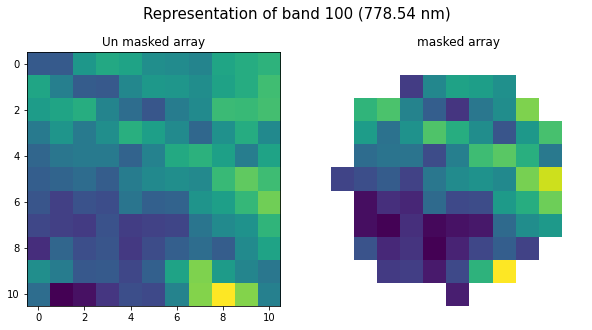

In [11]:
# display a single band 

#choose a sample 
rand_sample_path = train_gt.sample(n=1)['paths'].values[0]


with np.load(rand_sample_path) as f :
    arr = np.ma.MaskedArray(**f)


color_print(f'Shape of the selected sample image {arr.shape} (channels, height,width)')




fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 100
wavelen = wavelength.loc[band_id-1]


axs[0].imshow(arr[band_id,:,:].data)
plt.axis('off')
axs[0].set_title('Un masked array')

axs[1].imshow(arr[band_id,:,:])
plt.axis('off')
axs[1].set_title('masked array')




plt.suptitle(f'Representation of band {int(wavelen["band_no"])} ({wavelen["wavelength"]} nm)', fontsize=15)
plt.show()

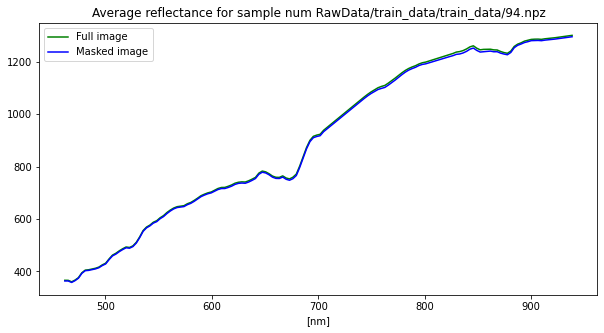

In [12]:
# displaying spectral curve 

fig,ax = plt.subplots(figsize=(10, 5))

masked_scene_mean_spectral_reflectance = [arr[i,:,:].mean() for i in range(arr.shape[0])]
full_scene_mean_spectral_reflectance = [arr[i,:,:].data.mean() for i in range(arr.shape[0])]

plt.plot(wavelength['wavelength'], full_scene_mean_spectral_reflectance, label='Full image',color='g')
plt.plot(wavelength['wavelength'], masked_scene_mean_spectral_reflectance, label='Masked image',color='b')

plt.xlabel('[nm]')
plt.legend()
plt.title(f'Average reflectance for sample num {rand_sample_path}')
plt.show()

Shape of the selected sample image (150, 101, 114) (channels, height,width)


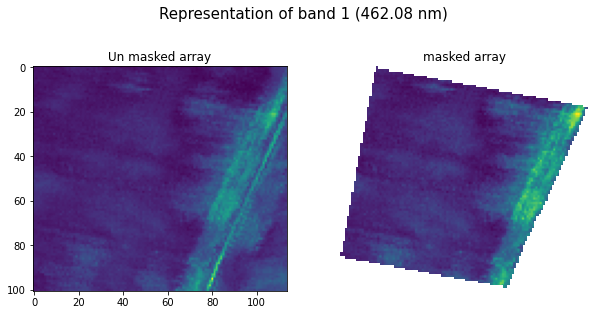

In [13]:
# display a single band 

#choose a sample 
rand_sample_path = train_gt.sample(n=1)['paths'].values[0]


with np.load(rand_sample_path) as f :
    arr = np.ma.MaskedArray(**f)

color_print(f'Shape of the selected sample image {arr.shape} (channels, height,width)')




fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 1
wavelen = wavelength.loc[band_id-1]


axs[0].imshow(arr[band_id,:,:].data)
plt.axis('off')
axs[0].set_title('Un masked array')

axs[1].imshow(arr[band_id,:,:])
plt.axis('off')
axs[1].set_title('masked array')




plt.suptitle(f'Representation of band {int(wavelen["band_no"])} ({wavelen["wavelength"]} nm)', fontsize=15)
plt.show()

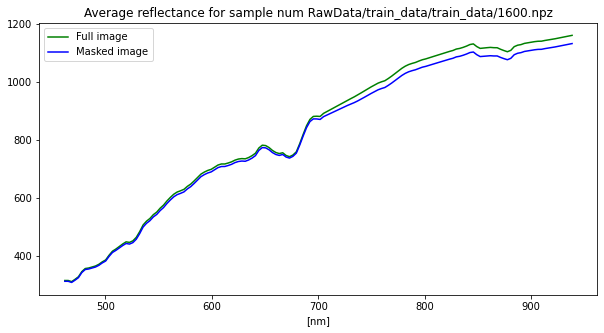

In [14]:
# displaying spectral curve 

fig,ax = plt.subplots(figsize=(10, 5))

masked_scene_mean_spectral_reflectance = [arr[i,:,:].mean() for i in range(arr.shape[0])]
full_scene_mean_spectral_reflectance = [arr[i,:,:].data.mean() for i in range(arr.shape[0])]

plt.plot(wavelength['wavelength'], full_scene_mean_spectral_reflectance, label='Full image',color='g')
plt.plot(wavelength['wavelength'], masked_scene_mean_spectral_reflectance, label='Masked image',color='b')

plt.xlabel('[nm]')
plt.legend()
plt.title(f'Average reflectance for sample num {rand_sample_path}')
plt.show()

Shape of the selected sample image (150, 28, 38) (channels, height,width)


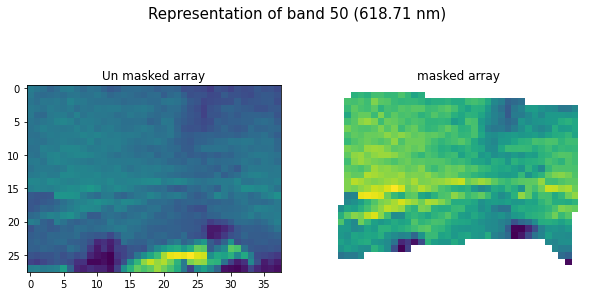

In [15]:
# display a single band 

#choose a sample 
rand_sample_path = train_gt.sample(n=1)['paths'].values[0]


with np.load(rand_sample_path) as f :
    arr = np.ma.MaskedArray(**f)

color_print(f'Shape of the selected sample image {arr.shape} (channels, height,width)')




fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 50
wavelen = wavelength.loc[band_id-1]


axs[0].imshow(arr[band_id,:,:].data)
plt.axis('off')
axs[0].set_title('Un masked array')

axs[1].imshow(arr[band_id,:,:])
plt.axis('off')
axs[1].set_title('masked array')




plt.suptitle(f'Representation of band {int(wavelen["band_no"])} ({wavelen["wavelength"]} nm)', fontsize=15)
plt.show()

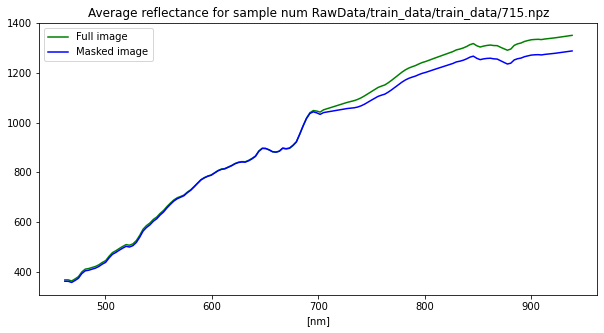

In [16]:
# displaying spectral curve 

fig,ax = plt.subplots(figsize=(10, 5))

masked_scene_mean_spectral_reflectance = [arr[i,:,:].mean() for i in range(arr.shape[0])]
full_scene_mean_spectral_reflectance = [arr[i,:,:].data.mean() for i in range(arr.shape[0])]

plt.plot(wavelength['wavelength'], full_scene_mean_spectral_reflectance, label='Full image',color='g')
plt.plot(wavelength['wavelength'], masked_scene_mean_spectral_reflectance, label='Masked image',color='b')

plt.xlabel('[nm]')
plt.legend()
plt.title(f'Average reflectance for sample num {rand_sample_path}')
plt.show()

# EDA on distribution of Soil Properties (Training_data)

<h3 style='color:green'> How is the distribution of Concetration on Phosphorous in soil?</h3>

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


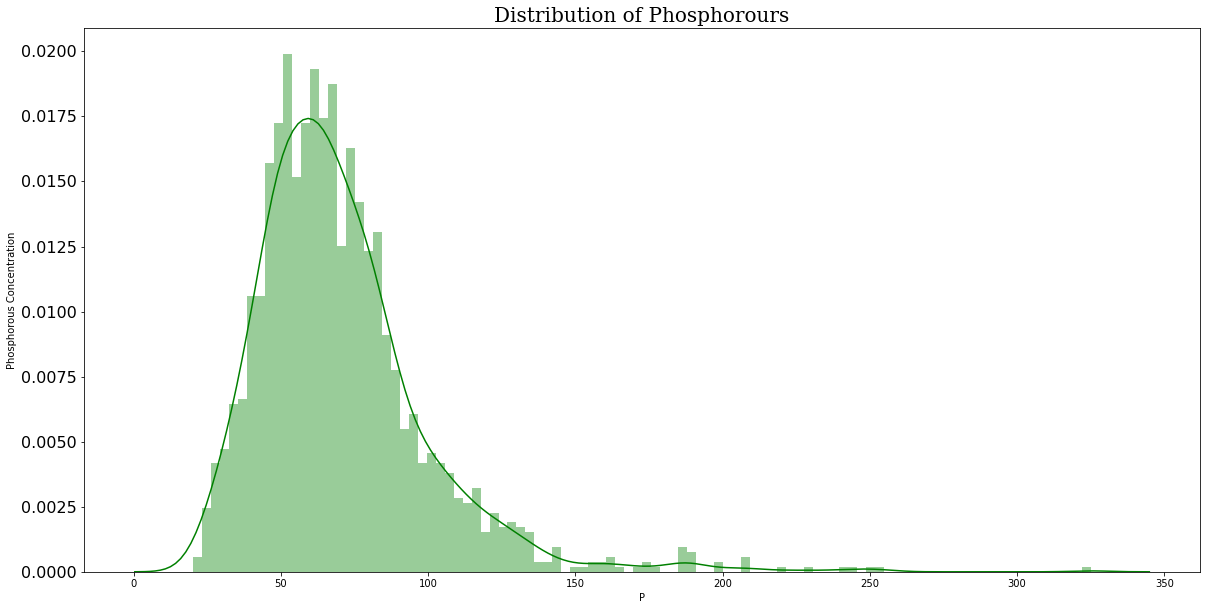

In [17]:
plt.figure(figsize=(20,10))
plt.yticks(fontsize=16)
sns.distplot(a = train_gt['P'],bins = 100,color = 'g')
plt.title("Distribution of Phosphorours",
          font="Serif", 
          size=20,
          color='k')
plt.ylabel('Phosphorous Concentration')

plt.show()



<h3 style='color:green'> How is the distribution of Concetration of Pottasium in soil?</h3>

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


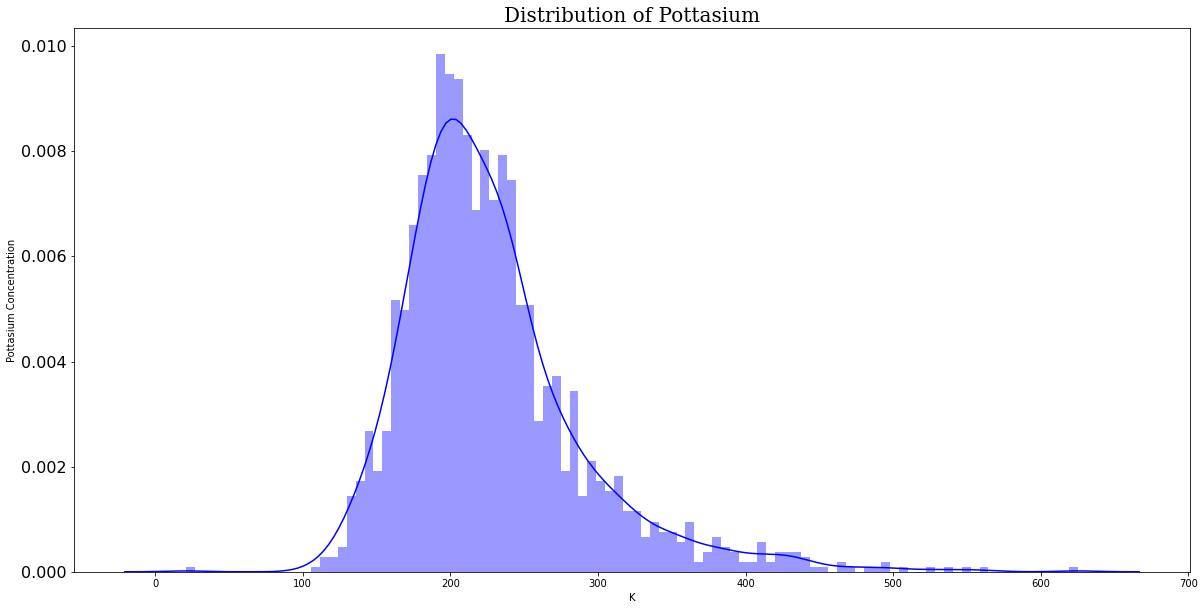

In [18]:
plt.figure(figsize=(20,10))
plt.yticks(fontsize=16)
sns.distplot(a = train_gt['K'],bins = 100,color = 'b')
plt.title("Distribution of Pottasium",
          font="Serif", 
          size=20,
          color='k')
plt.ylabel('Pottasium Concentration')

plt.show()




<h3 style='color:green'> How is the distribution of Concetration of Magnesium in soil?</h3>

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


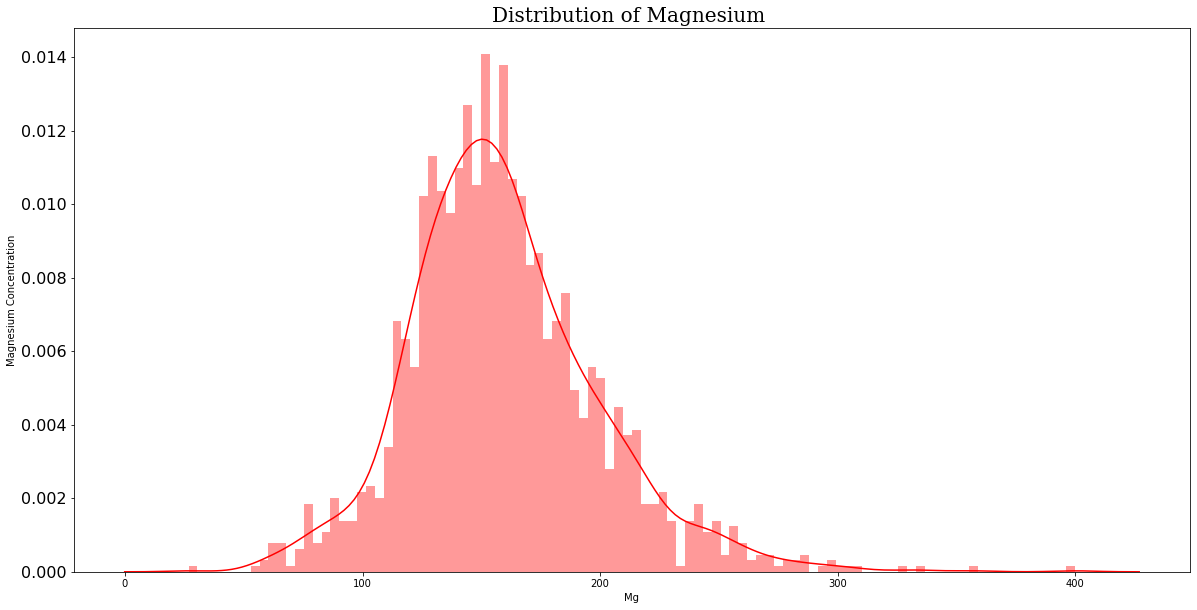

In [19]:
plt.figure(figsize=(20,10))
plt.yticks(fontsize=16)
sns.distplot(a = train_gt['Mg'],bins = 100,color = 'r')
plt.title("Distribution of Magnesium ",
          font="Serif", 
          size=20,
          color='k')
plt.ylabel('Magnesium Concentration')
plt.show()



<h3 style='color:green'> How is the distribution of Concetration of PH of soil? <br>"==7": Neutral  <br>" >7 ": Basic, <br>  " < 7" : Acidic </h3>

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


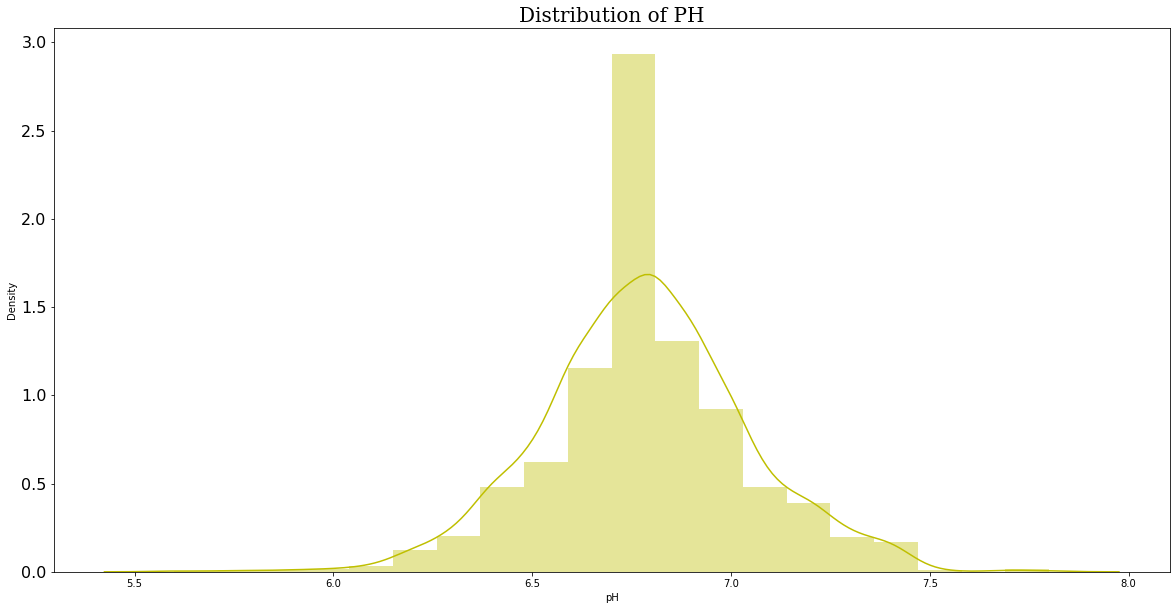

In [20]:
plt.figure(figsize=(20,10))
plt.yticks(fontsize=16)
sns.distplot(a = train_gt['pH'],bins = 20,color = 'y')
plt.title("Distribution of PH",
          font="Serif", 
          size=20,
          color='k')

plt.show()



# Checking Bands 

    This Hyperspectral data has about 150 bands , i.e 150 channels. Lets take a look at what band number corresponds to what channel.

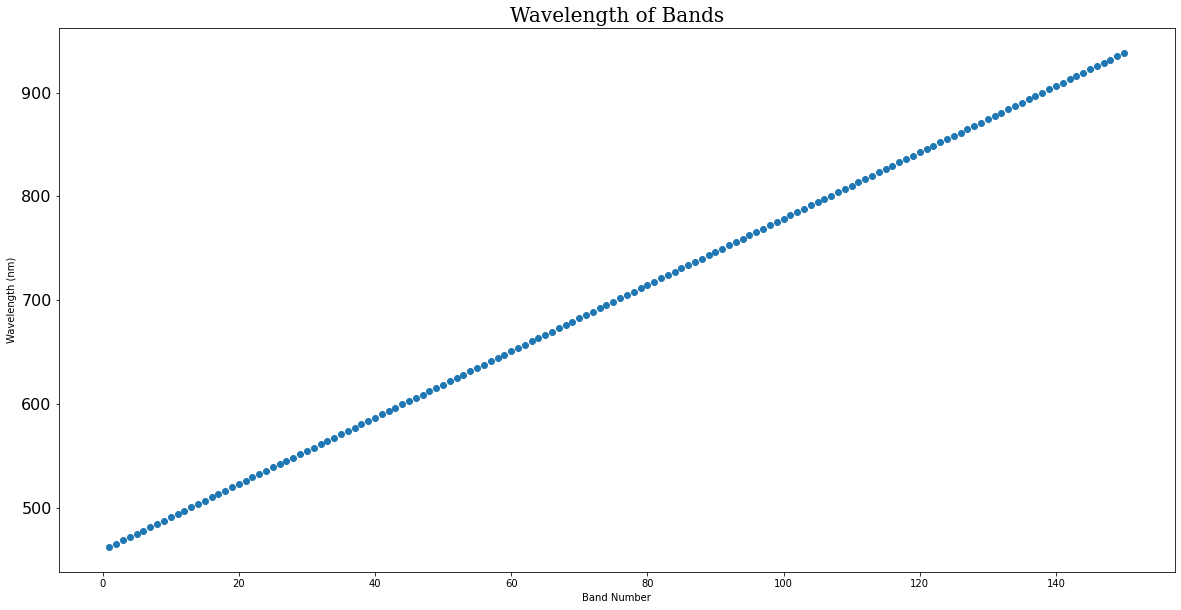

In [21]:
plt.figure(figsize=(20,10))
plt.yticks(fontsize=16)
plt.scatter(x = wavelength['band_no'],y = wavelength['wavelength'])
plt.title("Wavelength of Bands",
          font="Serif", 
          size=20,
          color='k')

plt.ylabel('Wavelength (nm)')
plt.xlabel('Band Number')
plt.show()



# Correlation between bands and image properties

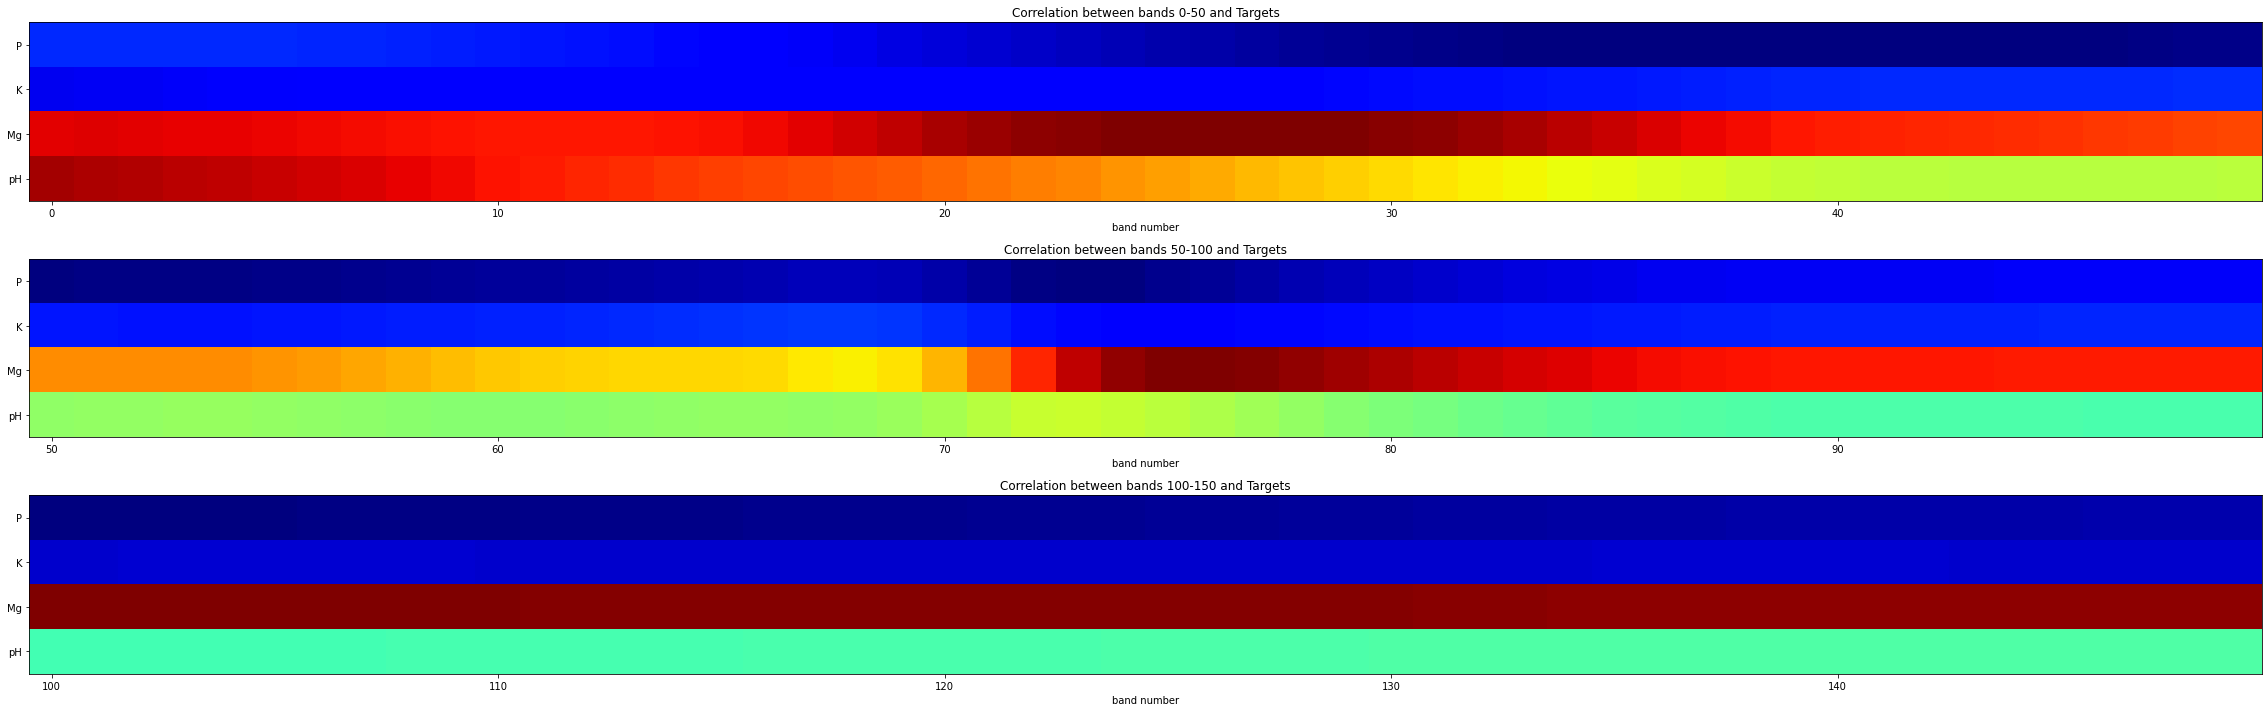

In [22]:
# make a dataset of mean values 

mean_values = []

for file_name in train_gt.paths:
    masked_arr = load_npz_file(file_name, masked=True,pad_mask=False)
    mean_vals = masked_arr.mean(axis=(1,2)) # take the mean value 
    mean_values.append(mean_vals)
    
    
mean_val_df = pd.DataFrame.from_records(mean_values,
                                        columns = wavelength.band_no.values)

del mean_values;gc.collect()

def get_correlation(df1,df2,columns):
    
    correlation_dict = {}
    
    for col in columns :
        corr_column = df1.corrwith(df2[col])
        
        correlation_dict[col] = corr_column
        
    return pd.DataFrame(correlation_dict)


corrs = get_correlation(df1 = mean_val_df,
                        df2 = train_gt, 
                        columns = ['P','K','Mg','pH']
                       )

fig,ax = plt.subplots(3,1,figsize=(60,10))



plt.subplot(3,1,1)
plt.imshow(corrs.iloc[:50,:].transpose().values,
           cmap='jet')
plt.yticks(ticks = [0,1,2,3],labels = ['P','K','Mg','pH'])

plt.title('Correlation between bands 0-50 and Targets')
plt.xlabel('band number')



plt.subplot(3,1,2)
plt.imshow(corrs.iloc[50:100,:].transpose().values,
           cmap='jet')

plt.yticks(ticks = [0,1,2,3],labels = ['P','K','Mg','pH'])
plt.xticks(ticks = np.arange(0,50,10),labels = np.arange(50,100,10))
plt.xlabel('band number')
plt.title('Correlation between bands 50-100 and Targets')


plt.subplot(3,1,3)

plt.imshow(corrs.iloc[100:,:].transpose().values,
           cmap='jet')

plt.yticks(ticks = [0,1,2,3],labels = ['P','K','Mg','pH'])
plt.xticks(ticks = np.arange(0,50,10),labels = np.arange(100,150,10))
plt.xlabel('band number')
plt.title('Correlation between bands 100-150 and Targets')

plt.tight_layout()

plt.show()

**Checking range of data values(for scaling Images)**

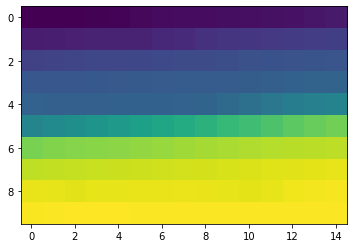

In [23]:
band_vals = []
heights = []
widths = []

for rast in train_gt.paths:
    arr = load_npz_file(rast,masked=True,pad_mask=False)
    
    # take max value 
    max_vals = arr.max(axis=(1,2))
    band_vals.append(max_vals)
    
    # get image heights and widths 
    unmasked = arr.data 
    
    c,h,w = unmasked.shape
    
    heights.append(h)
    widths.append(w)
    
    
    
band_vals= np.array(band_vals)
    
mean_band_vals = band_vals.mean(axis=0)

plt.imshow(mean_band_vals.reshape((10,15)))

**Distribution of Image Height and widths**

    Images have different heights and widths, so lets take a look at that distribution 

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


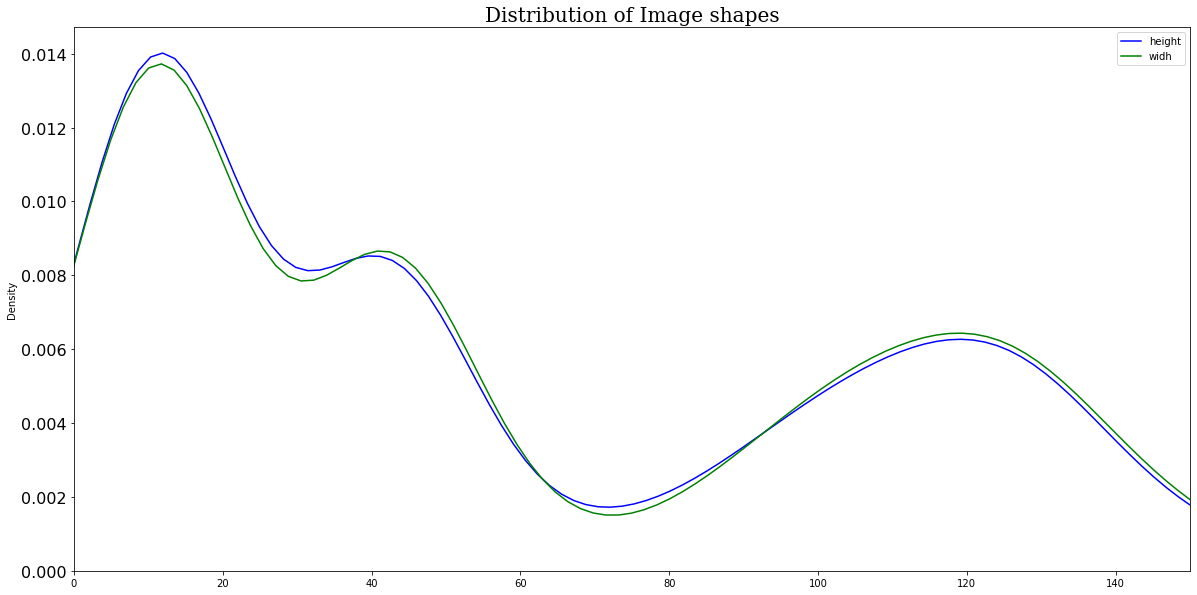

In [24]:
plt.figure(figsize=(20,10))
plt.yticks(fontsize=16)

sns.distplot(a = heights,color = 'b',label = 'height',hist=False)
sns.distplot(a = widths,color = 'g',label = 'widh',hist=False)

plt.title("Distribution of Image shapes",
          font="Serif", 
          size=20,
          color='k')
plt.xlim((0,150))

plt.legend()

plt.show()


# Building Train and test datasets 

In [93]:
def load_and_reshape(filepath):
    '''load and reshape array'''
    
    
    #load array
    arr = load_npz_file(filepath,
                        masked=False,
                        pad_mask=False)
    
    depth,height,width = arr.shape
    
    # reshape to depth last format 
    arr = arr.reshape((height,width,depth))
    
    #scale values 
#     arr = arr / scaling_values
    
    #resize 
#     arr = cv2.resize(arr,CFG.img_size)
    
    return arr


def get_array_properties(arr):
    '''get reduced properties for array with shape (h,w,channels==150)'''
    
    #area of array 
    area_arr = arr[:,:,0].size
    
    
    #max min range
    arr_max = arr.max(axis=(0,1))
    arr_range = arr_max - arr.min(axis=(0,1))
    
    
    
    #central tendencies 
    mean_arr = arr.mean(axis=(0,1))
    std_arr = arr.std(axis=(0,1))
    
    median_arr = np.median(arr,axis=(0,1))
    
    #first 25 %
    q1 = np.percentile(a=arr,q=25,axis=(0,1))
    #last 25 % 
    q3 = np.percentile(a=arr,q=75,axis=(0,1))
    
    
    #iqr 
    iqr = q3 - q1
    
    
    
    #first 10 
    d1 = np.percentile(a=arr,q=10,axis=(0,1))
    
    
    #last 10
    d10 = np.percentile(a=arr,q=90,axis=(0,1))
    
    
    
    return np.array((area_arr,*mean_arr,*std_arr,*median_arr,*q1,*q3,*arr_max,*arr_range,*d1,*d10,*iqr))
    

def get_agg_properties(filepath):
    arr = load_and_reshape(filepath)
    
    # properties of each band(range of each band)

    properties = get_array_properties(arr)
    
    
    return properties
    

# generate Training data 

**Using multiprocessing to spped up processing**

In [94]:
%%time

array_cols = ['array_area',
              *[f'mean_{i}' for i in range(1,151)],
              *[f'std_{i}' for i in range(1,151)],
              *[f'med_{i}' for i in range(1,151)],
              *[f'q1_{i}' for i in range(1,151)],
              *[f'q3_{i}' for i in range(1,151)],
              *[f'max_{i}' for i in range(1,151)],
              *[f'range_{i}' for i in range(1,151)],
             *[f'D1_{i}' for i in range(1,151)],
             *[f'D10_{i}' for i in range(1,151)],
             *[f'IQR_{i}' for i in range(1,151)]]


pool =mp.Pool()
# create training data
X_train_1=pd.DataFrame.from_records(pool.map(func=get_agg_properties,
                                           iterable = train_gt.paths.values),
                                    columns = array_cols
                                    )

# pool.join()
pool.close()


y_train = train_gt[CFG.classes]


X_train_1.shape,y_train.shape

CPU times: user 1.41 s, sys: 384 ms, total: 1.79 s
Wall time: 55.9 s


((1732, 1501), (1732, 4))

In [95]:
%%time
pool =mp.Pool()
# create training data
X_test_1=pd.DataFrame.from_records(pool.map(func=get_agg_properties,
                                         iterable = test_csv.paths.values),
                                 columns = array_cols
                                )

# pool.join()
pool.close()

X_test_1.shape

CPU times: user 913 ms, sys: 256 ms, total: 1.17 s
Wall time: 37.4 s


(1154, 1501)

**Dimensionality reduction of features using PCA**

In [96]:
def pca_on_band(df,
                band_num,
                n_components = 2):
    
    '''get pca features for a particular band'''
    
    pca_pipe = Pipeline(steps = [('standard_scaler',StandardScaler()),
                                 ('pca',PCA(n_components=n_components))
                                 ]
                       )
    
    band_cols = [col for col in  df.columns if str(band_num) in col]
    
    
    pca_pipe.fit(df[band_cols])
    features = pca_pipe.transform(df[band_cols])
    
#     print(f'explained variance for band {band_num } is :',pca_pipe['pca'].explained_variance_ratio_)

    return pd.DataFrame(features,
                        columns = [f'B{band_num}_PC{i+1}' for i in range(n_components)]
                        )



def get_pca_dataset(df):
    
    all_df = []
    
    for band in range(1,151):
        band_pca = pca_on_band(df,band)
        
        all_df.append(band_pca)
        
        
    return pd.concat(objs=all_df, axis=1, join='outer', ignore_index=False)




    

In [ ]:
pca_train = get_pca_dataset(X_train_1)
pca_test = get_pca_dataset(X_test_1)

In [99]:
derived_cols = ['array_area',*[f'q1_{i}' for i in range(1,151)],*[f'q3_{i}' for i in range(1,151)]]


X_train = pca_train.merge(X_train_1[derived_cols],how='inner',left_index=True,right_index=True)

X_train.shape

(1732, 601)

In [100]:

X_test = pca_test.merge(X_test_1[derived_cols],how='inner',left_index=True,right_index=True)

X_test.shape

(1154, 601)

# Hyperparam optimization 

In [ ]:
class catboost_optimization:
    def __init__(self,
                 X,
                 y,
                 params=None,
                 categorical = None,
                 seed=CFG.seed,
                 cv = KFold(n_splits = 3),
                 variance_penalty = 1 
                ):
        self.params = params
        self.seed   = seed
        self.categorical = categorical
        self.X = X
        self.y = y
        self.cv = cv
        self.variance_penalty = variance_penalty # penalty to variance 
        
        

    def objective(self,
                  trial:optuna.Trial):
        
        
        
        self.params = {
                'verbose'        : 1,
               'loss_function'  :'MultiRMSE',
               'depth'          :trial.suggest_int('depth',4,10),
               'learning_rate'  :trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
               'l2_leaf_reg'    :trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),
               'random_strength':trial.suggest_uniform('random_strength',1e-2,0.5),
               'max_bin'        :trial.suggest_int('max_bin',64,254),
               'grow_policy'    :trial.suggest_categorical('grow_policy',
                                                           ['SymmetricTree','Depthwise']),
               'iterations'     :trial.suggest_int('iterations',200,100),
#                'max_leaves'     :trial.suggest_int('max_leaves',2,64),
               "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.3, 0.8),
#                "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
               "bootstrap_type": trial.suggest_categorical("bootstrap_type",
                                                            ["Bayesian", "MVS",'Bernoulli']),
               'eval_metric': 'MultiRMSE'
                }
        
        
        metrics = []
        

        for train_idx,val_idx in self.cv.split(self.X,self.y):
            x_t,x_v=X.iloc[train_idx],X.iloc[val_idx]
            y_t,y_v=y.iloc[train_idx],y.iloc[val_idx]

        
            try:
                model = CatBoostRegressor(**self.params)

                model.fit(x_tr,y_tr,
                         eval_set=[(x_ts,y_ts)],
                         verbose=0,
                         cat_features=self.categorical,
                         early_stopping_rounds=300)


                preds=model.predict(x_ts)

                acc= mean_squared_error(y_ts,preds)
                
                #saved accuracy for each fold 
                metrics.append(acc)
                

 
            except Exception as e:
                print(e)
            
            
        return np.mean(metrics) -

    def get_best_params(self,
                        n_trials = 30,
                        time_out=9000,
                        direction= 'minimize'):
        
        print(f'Running optimization for {time_out} seconds / {n_trials} Trials')
        
        
        sampler = optuna.samplers.TPESampler(seed=self.seed)  # Make the sampler behave in a deterministic way.(samples trial hyperparams)

        self.study=optuna.create_study(direction=direction,
                                       study_name='hypm_opt',
                                        sampler=sampler)
        
        self.study.optimize(self.objective,
                           n_trials=n_trials,
                           timeout=time_out)

        print("Number of finished trials: {}".format(len(self.study.trials)))

        return self.study.best_trial.params

    def plot_history(self):
        '''plot optimization history :
        credits : https://medium.com/databulls/tps-mar21-leaderboard-14-xgb-catboost-lgbm-optuna-cdffb5124368'''
        optuna.visualization.plot_optimization_history(self.study)
        
    def plot_param_importances(self):
        '''plot param imp'''
        optuna.visualization.plot_param_importances(self.study)
        
        



catb_optimizer = catboost_optimization(X=X_train,
                                       y=y_train,
                                       )


best_params = catb_optimizer.get_best_params(n_trials = 50, # number of trials 
                                            time_out=3000, # time out in seconds 
                                            direction= 'minimize')  # run hyperparam optimization



**Update best params**

In [104]:
best_params = {'depth': 8, 'learning_rate': 0.09235140300552763, 'l2_leaf_reg': 2.678022999500673, 'random_strength': 0.17162925472695167, 'max_bin': 146, 'grow_policy': 'Depthwise', 'iterations': 442, 'colsample_bylevel': 0.6316056669260965, 'bootstrap_type': 'Bernoulli'}

best_params.update({'iterations':1000,
                    'verbose':0,
                    'loss_function'  :'MultiRMSE',
                    'eval_metric': 'MultiRMSE'}
                  )


CFG.best_params = best_params

best_params



{'depth': 8,
 'learning_rate': 0.09235140300552763,
 'l2_leaf_reg': 2.678022999500673,
 'random_strength': 0.17162925472695167,
 'max_bin': 146,
 'grow_policy': 'Depthwise',
 'iterations': 1000,
 'colsample_bylevel': 0.6316056669260965,
 'bootstrap_type': 'Bernoulli',
 'verbose': 0,
 'loss_function': 'MultiRMSE',
 'eval_metric': 'MultiRMSE'}

# Model fitting

In [105]:
class my_estimator:
    def __init__(self,
                 estimator):
        self.estimator_obj = estimator
        self.estimator_list = []
        
    def fit(self,
            X,
            y,
            params= {},
            categorical=None):
        
        '''fit X,y to the data'''
        
        self.params= params
        self.estimator = self.estimator_obj(**self.params)
        
        if isinstance(categorical,(list,str)):
            self.estimator.fit(X,y,
                               cat_features = categorical)
        else:
            self.estimator.fit(X,y)
            
        return None
            
    def predict(self,X_test):
        '''predict using estimator'''
        
        if not self.estimator:
            print("Fit the model using 'model.fit(X,y)' first!")
            
        return self.estimator.predict(X_test)
    
    def fit_in_folds(self,
                     X,
                     y,
                     categorical=None,
                     params={},
                     eval_metric = mean_squared_error,
                     cv=KFold(n_splits=10)):
        '''fit multiple models using k-fold cross validation strategy'''
        self.n =1
        self.params = params
           

        for train_idx,val_idx in cv.split(X,y):

            x_t,x_v=X.iloc[train_idx],X.iloc[val_idx]
            y_t,y_v=y.iloc[train_idx],y.iloc[val_idx]

            self.estimator=self.estimator_obj(**self.params)    

            print(f'fitting on fold {self.n} ')

            if isinstance(categorical,(list,str)):
                self.estimator.fit(x_t,y_t,
                                   cat_features = categorical)
            else:
                self.estimator.fit(x_t,y_t)

            
            
            
            print('Validation score for fold {} is {}'.format(self.n,eval_metric(y_v,
                                                                           self.estimator.predict(x_v)
                                                                          )
                                                              )
                 )
            
            
            
            self.n+=1

            self.estimator_list.append(self.estimator) # store fitted models

            

        return None

    def predict_in_folds(self,
                         X_test):
        
        if len(self.estimator_list) <1:
            print("Fit the data on multiple folds by calling 'model.fit_in_folds(X,y)' ")
        else:
            predictions_list = []
            for model in self.estimator_list:
                pred = model.predict(X_test)
                
                predictions_list.append(pred)
                
            predictions = np.array(predictions_list).T  # (n,m) dim array, where n is number of examples and m is number of models
        
        
        return predictions
            
    def aggregate_predictions(self,
                              predictions,
                              agg='mean',
                              axis=1):
        '''aggregate predictions'''
        
        
        if agg == 'mean':
            return predictions.mean(axis=axis)
        elif agg == 'median':
            return np.median(a= predictions,
                             axis=axis)
                   
        else:
            print("assign 'agg' to either of ['mean','median']")
            
            return None

In [107]:
%%time


#create a instance of estimator
estimator = my_estimator(estimator=CatBoostRegressor)


#fit on multiple folds 
estimator.fit_in_folds(X = X_train,
                       y = y_train,
                      categorical=None,
                      params=CFG.best_params,
                      eval_metric = mean_squared_error,
                      cv=KFold(n_splits=3)
                      )

fitting on fold 1 
Validation score for fold 1 is 2265.8551655709293
fitting on fold 2 
Validation score for fold 2 is 1901.6768876470765
fitting on fold 3 
Validation score for fold 3 is 2754.453039462639
CPU times: user 45min 47s, sys: 34.4 s, total: 46min 21s
Wall time: 12min 8s


# Evaluate Train Predictions

In [109]:

# prediction on validation data
predictions_val_tr = estimator.predict_in_folds(X_test = X_train)


#get mean value of predictions
mean_pred_val_tr = pd.DataFrame(estimator.aggregate_predictions(predictions_val_tr,
                                                agg='mean',
                                                axis=-1).T,
                            columns = ['P', 'K', 'Mg', 'pH']
                               )

print(f'MSE Total (mean_predictions) =  {mean_squared_error(y_train,mean_pred_val_tr)}')



for column in mean_pred_val_tr.columns:
    print(f'MSE for predicted (mean of cv) {column} is {mean_squared_error(y_train[column],mean_pred_val_tr[column])}')



#get median value of predictions
med_pred_val_tr =  pd.DataFrame(estimator.aggregate_predictions(predictions_val,
                                               agg='median',
                                               axis=-1).T,
                            columns = ['P', 'K', 'Mg', 'pH'])

print(f'MSE Total (median_predictions) =  {mean_squared_error(y_train,med_pred_val_tr)}')


for column in med_pred_val_tr.columns:
    print(f'MSE for predicted (median of cv) {column} is {mean_squared_error(y_train[column],mean_pred_val_tr[column])}')


MSE Total (mean_predictions) =  273.91936334945524
MSE for predicted (mean of cv) P is 140.1168618725612
MSE for predicted (mean of cv) K is 732.8129773758358
MSE for predicted (mean of cv) Mg is 222.73441071689638
MSE for predicted (mean of cv) pH is 0.013203432527781786
MSE Total (median_predictions) =  508.2816505717814
MSE for predicted (median of cv) P is 140.1168618725612
MSE for predicted (median of cv) K is 732.8129773758358
MSE for predicted (median of cv) Mg is 222.73441071689638
MSE for predicted (median of cv) pH is 0.013203432527781786


# Prediction on Test

In [111]:


# prediction on validation data
predictions_val = estimator.predict_in_folds(X_test = X_test)


#get mean value of predictions
mean_pred_val = pd.DataFrame(estimator.aggregate_predictions(predictions_val,
                                                agg='mean',
                                                axis=-1).T,
                            columns = ['P', 'K', 'Mg', 'pH'])



#get median value of predictions
med_pred_val =  pd.DataFrame(estimator.aggregate_predictions(predictions_val,
                                               agg='median',
                                               axis=-1).T,
                            columns = ['P', 'K', 'Mg', 'pH'])



# Distribution of predictions 

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


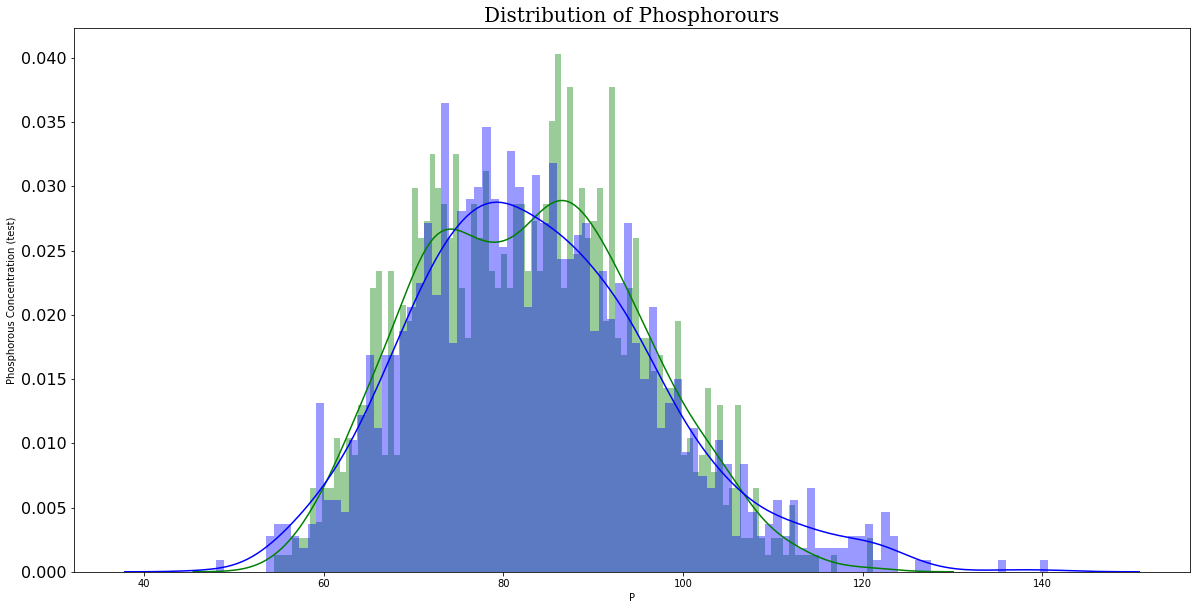

In [112]:
plt.figure(figsize=(20,10))
plt.yticks(fontsize=16)
sns.distplot(a = mean_pred_val['P'],bins = 100,color = 'g',label='mean')
sns.distplot(a = med_pred_val['P'],bins = 100,color = 'b',label='median')

plt.title("Distribution of Phosphorours",
          font="Serif", 
          size=20,
          color='k')
plt.ylabel('Phosphorous Concentration (test)')

plt.show()


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


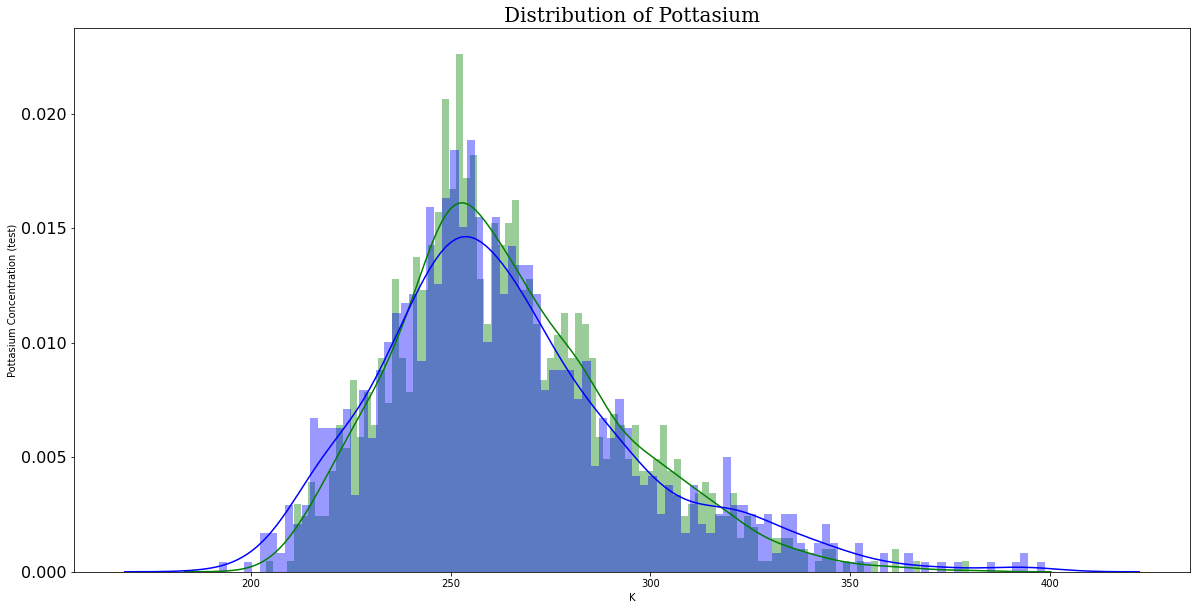

In [113]:
plt.figure(figsize=(20,10))
plt.yticks(fontsize=16)
sns.distplot(a = mean_pred_val['K'],bins = 100,color = 'g',label='mean')
sns.distplot(a = med_pred_val['K'],bins = 100,color = 'b',label='median')

plt.title("Distribution of Pottasium",
          font="Serif", 
          size=20,
          color='k')
plt.ylabel('Pottasium Concentration (test)')

plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


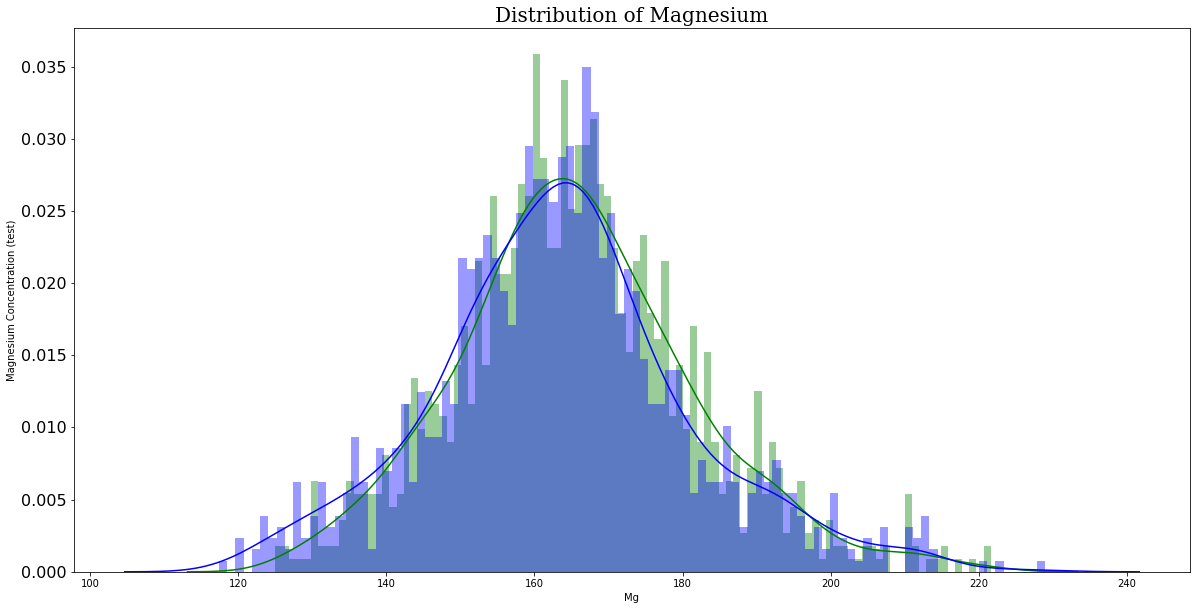

In [114]:
plt.figure(figsize=(20,10))
plt.yticks(fontsize=16)
sns.distplot(a = mean_pred_val['Mg'],bins = 100,color = 'g',label='mean')
sns.distplot(a = med_pred_val['Mg'],bins = 100,color = 'b',label='median')

plt.title("Distribution of Magnesium",
          font="Serif", 
          size=20,
          color='k')
plt.ylabel('Magnesium Concentration (test)')

plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


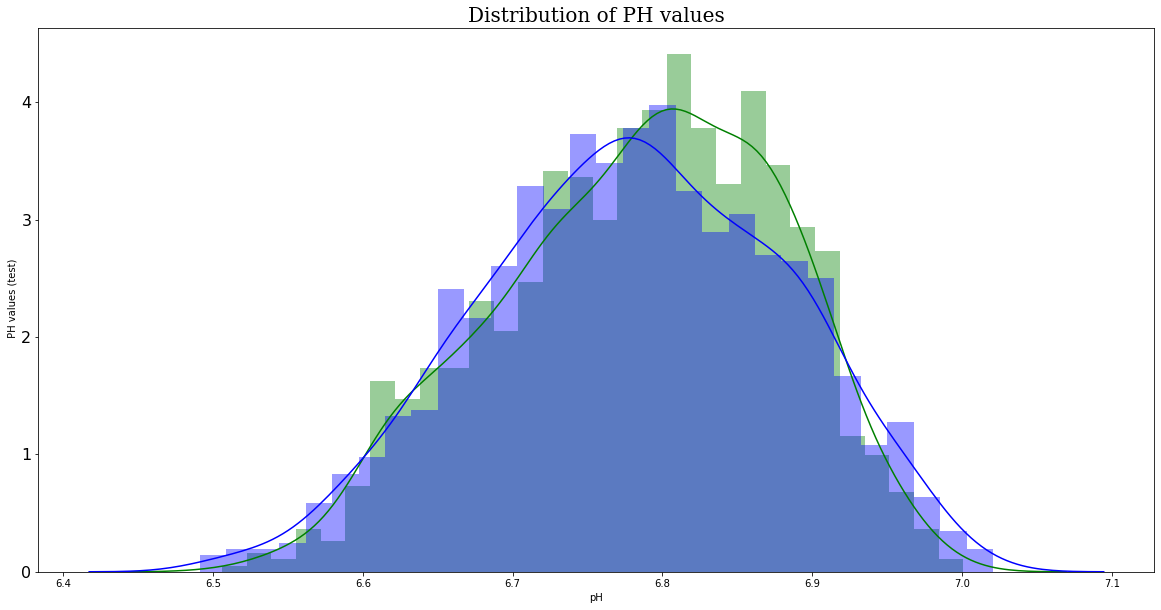

In [115]:
plt.figure(figsize=(20,10))
plt.yticks(fontsize=16)
sns.distplot(a = mean_pred_val['pH'],bins = 30,color = 'g',label='mean')
sns.distplot(a = med_pred_val['pH'],bins = 30,color = 'b',label='median')

plt.title("Distribution of PH values",
          font="Serif", 
          size=20,
          color='k')
plt.ylabel(' PH values (test)')

plt.show()

# Submission

In [116]:
mean_pred_val.to_csv("pred_mean.csv",index_label="sample_index")

!zip mean_sub.zip pred_mean.csv
!rm pred_mean.csv

updating: pred_mean.csv (deflated 50%)


In [117]:
med_pred_val.to_csv("pred_med.csv",index_label="sample_index")

!zip med_sub.zip pred_med.csv
!rm pred_med.csv

updating: pred_med.csv (deflated 50%)


In [118]:
!ls

RawData  __notebook_source__.ipynb  catboost_info  mean_sub.zip  med_sub.zip
